Copyright 2021 Takehiro Ajioka

### Enviroment

Python 3.6
Anaconda
tensorflow-gpu==1.15.0
keras==2.3.1
shap==0.36.0
tfdeterminism==0.3.0

In [1]:
# Ignore warning
import os
import tensorflow as tf
import logging
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)

In [2]:
import numpy
import pandas
import matplotlib.pyplot as plt
from scipy import io
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, ConvLSTM2D, Bidirectional
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

In [3]:
# Allow grouth option of GPU
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [4]:
# Load data
signal = io.loadmat('../data/signal_5mice.mat')
runrest = io.loadmat('../data/runrest_5mice.mat')

In [5]:
plt.rcParams["font.size"] = 18

# Preprocess

In [6]:
# Mini-max normalization
def mini_max(dataset):
    min_value = dataset.min(axis=0)
    max_value = dataset.max(axis=0)
    dataset_nor = (dataset - min_value) / (max_value - min_value)
    return dataset_nor

In [7]:
# Create input data [-n,n+1]
def create_dataset(dataset, look_frame):
    dataX, dataY = [], []
    for i in range(look_frame,len(dataset)-(look_frame)):
        xset = []
        for j in range(dataset.shape[1]-1):
            a = dataset[(i-look_frame):(i+look_frame+1), j]
            xset.append(a)
        dataY.append(dataset[i, -1])      
        dataX.append(xset)
    return numpy.array(dataX), numpy.array(dataY)

In [8]:
look_frame = 15 #read the previous and next n frames as input

def Data_preprocess(signal, runrest, region):
    # Normalize
    signal = mini_max(signal.transpose())
    runrest = runrest.transpose()
    # Delete signals of unselected region
    signal[:,list(set(range(50))-region)] = 0
    # Create dataset
    dataset = numpy.hstack([signal.astype('float32'), runrest.astype('float32')])
    X, Y = create_dataset(dataset, look_frame)
    return X, Y

In [9]:
def Get_Dataset(TEST, REGION):
    print('TEST')
    # Test dataset
    testX = numpy.empty([0,50,31], dtype=numpy.float32)
    testY = numpy.empty(0, dtype=numpy.float32)
    for i in TEST:
        print(f'Mouse {i}')
        for j in range(signal['signal'+str(i)].shape[1]):
            X, Y = Data_preprocess(signal['signal'+str(i)][0,j], runrest['runrest'+str(i)][0,j], REGION)
            testX = numpy.concatenate([testX, X], axis=0)
            testY = numpy.concatenate([testY, Y], axis=0)

    return testX, testY

# Evaluate

In [10]:
# region number to index
def region_index(region_num):
    region_index = []
    for re in region_num:
        region_index.append(re - 1)
    return set(region_index)

In [11]:
# Select 4 regions
selected_region = [6,8,31,33]

In [12]:
# Region number
WHOLE = list(range(1,51))
FOUR = selected_region
OTHER = list(set(WHOLE)-set(selected_region))
print(WHOLE)
print(FOUR)
print(OTHER)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
[6, 8, 31, 33]
[1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


In [13]:
REGIONS = {'Whole_region':region_index(WHOLE), 'Region_6-8-31-33':region_index(FOUR), 'Other_than_4_regions':region_index(OTHER)}

In [14]:
import itertools

In [15]:
Models = ['GRU']

In [16]:
# Plot ROC curve
def plot_roc(y_pred, y_test, mode):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    AUC = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
    plt.title(mode + " ROC curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    print('AUC: {:.3f}'.format(AUC))
    opt_thr = thresholds[numpy.argmax(tpr - fpr)]
    print('Optimal threshold: {:.3f}'.format(opt_thr))
    return AUC

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 1


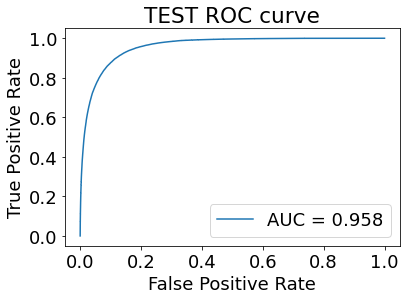

AUC: 0.958
Optimal threshold: 0.316
197670/197670 [==============================] - 42s 213us/sample - loss: 0.2553 - acc: 0.8914
{32, 5, 30, 7}
TEST
Mouse 1


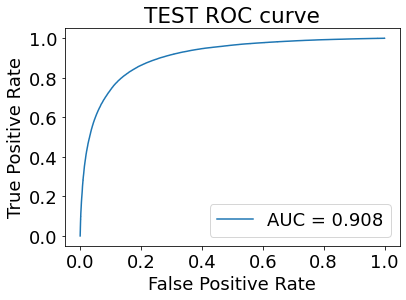

AUC: 0.908
Optimal threshold: 0.264
197670/197670 [==============================] - 43s 217us/sample - loss: 0.3805 - acc: 0.8376
{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 1


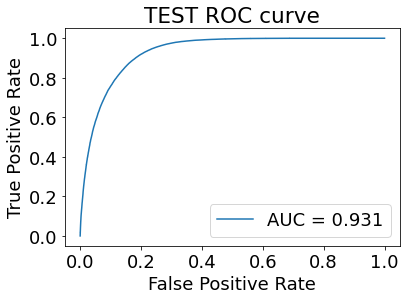

AUC: 0.931
Optimal threshold: 0.641
197670/197670 [==============================] - 43s 217us/sample - loss: 0.4916 - acc: 0.8333
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 1


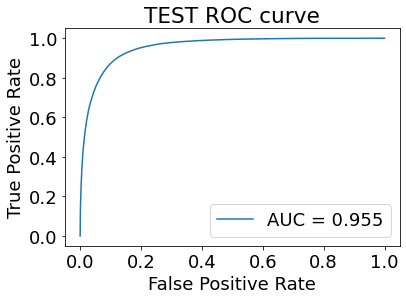

AUC: 0.955
Optimal threshold: 0.109
197670/197670 [==============================] - 43s 216us/sample - loss: 0.3364 - acc: 0.8531
{32, 5, 30, 7}
TEST
Mouse 1


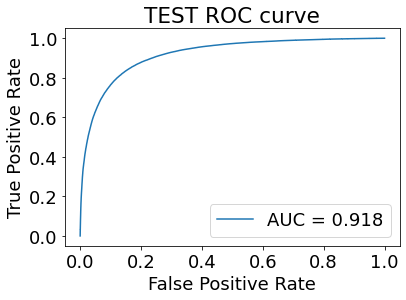

AUC: 0.918
Optimal threshold: 0.223
197670/197670 [==============================] - 42s 214us/sample - loss: 0.3718 - acc: 0.8431
{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 1


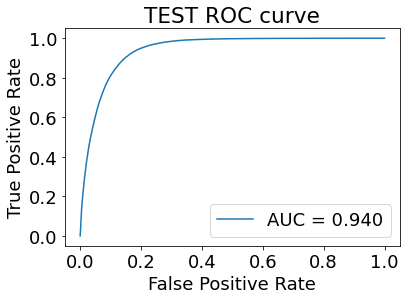

AUC: 0.940
Optimal threshold: 0.359
197670/197670 [==============================] - 43s 219us/sample - loss: 0.3304 - acc: 0.8708
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 1


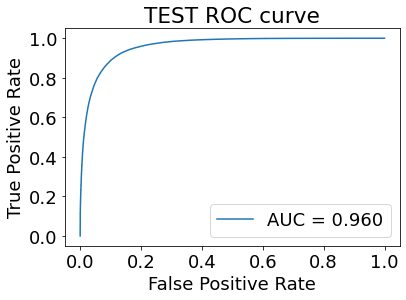

AUC: 0.960
Optimal threshold: 0.104
197670/197670 [==============================] - 43s 216us/sample - loss: 0.3264 - acc: 0.8559
{32, 5, 30, 7}
TEST
Mouse 1


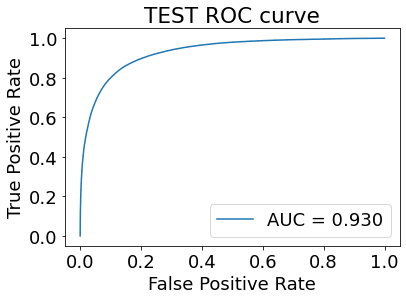

AUC: 0.930
Optimal threshold: 0.194
197670/197670 [==============================] - 43s 216us/sample - loss: 0.3522 - acc: 0.8532
{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 1


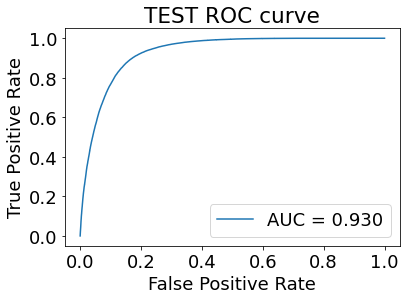

AUC: 0.930
Optimal threshold: 0.270
197670/197670 [==============================] - 43s 216us/sample - loss: 0.3548 - acc: 0.8580
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 1


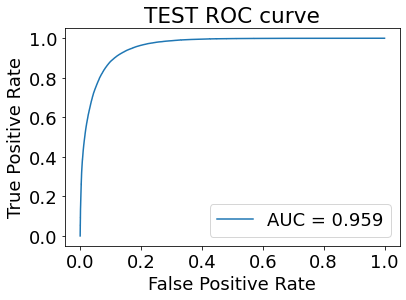

AUC: 0.959
Optimal threshold: 0.073
197670/197670 [==============================] - 43s 219us/sample - loss: 0.3449 - acc: 0.8524
{32, 5, 30, 7}
TEST
Mouse 1


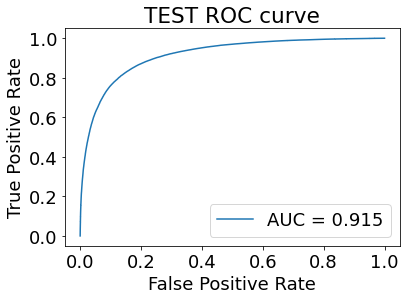

AUC: 0.915
Optimal threshold: 0.260
197670/197670 [==============================] - 43s 219us/sample - loss: 0.3692 - acc: 0.8419
{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 1


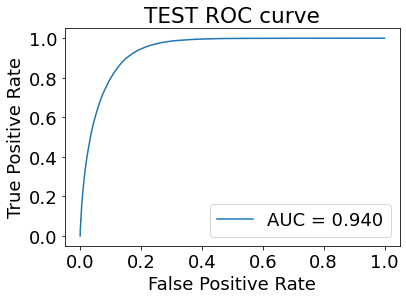

AUC: 0.940
Optimal threshold: 0.126
197670/197670 [==============================] - 44s 220us/sample - loss: 0.3380 - acc: 0.8547
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 2


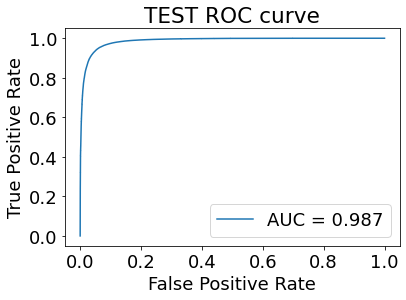

AUC: 0.987
Optimal threshold: 0.551
215640/215640 [==============================] - 48s 222us/sample - loss: 0.1443 - acc: 0.9485
{32, 5, 30, 7}
TEST
Mouse 2


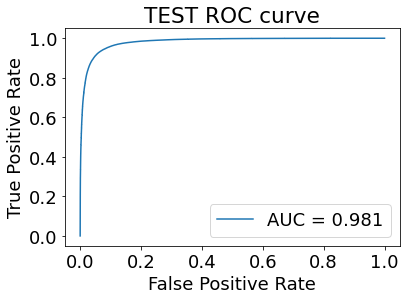

AUC: 0.981
Optimal threshold: 0.565
215640/215640 [==============================] - 48s 221us/sample - loss: 0.1672 - acc: 0.9366
{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 2


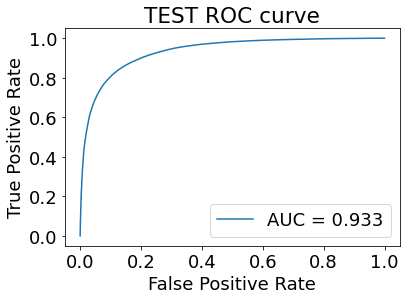

AUC: 0.933
Optimal threshold: 0.078
215640/215640 [==============================] - 48s 225us/sample - loss: 0.6890 - acc: 0.7650
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 2


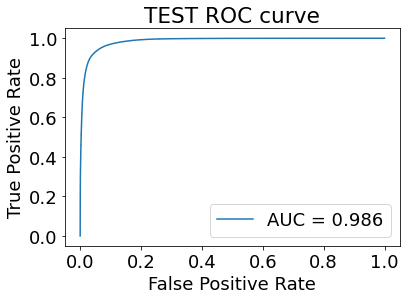

AUC: 0.986
Optimal threshold: 0.439
215640/215640 [==============================] - 48s 224us/sample - loss: 0.1625 - acc: 0.9404
{32, 5, 30, 7}
TEST
Mouse 2


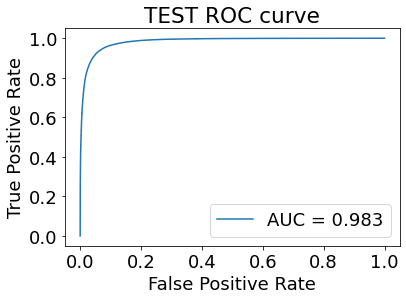

AUC: 0.983
Optimal threshold: 0.684
215640/215640 [==============================] - 48s 224us/sample - loss: 0.1532 - acc: 0.9422
{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 2


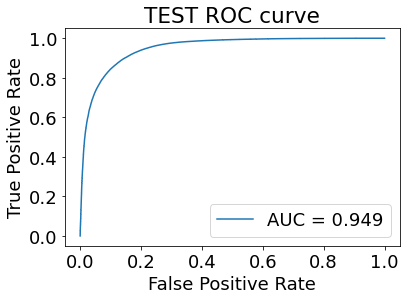

AUC: 0.949
Optimal threshold: 0.158
215640/215640 [==============================] - 49s 228us/sample - loss: 0.4374 - acc: 0.8411
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 2


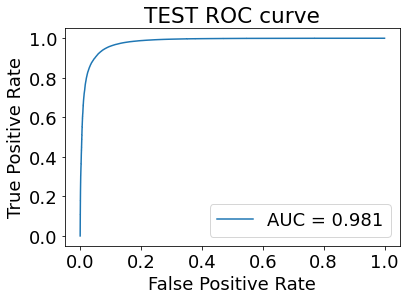

AUC: 0.981
Optimal threshold: 0.363
215640/215640 [==============================] - 48s 224us/sample - loss: 0.1944 - acc: 0.9239
{32, 5, 30, 7}
TEST
Mouse 2


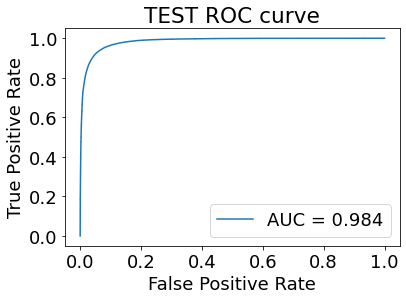

AUC: 0.984
Optimal threshold: 0.607
215640/215640 [==============================] - 48s 223us/sample - loss: 0.1539 - acc: 0.9421
{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 2


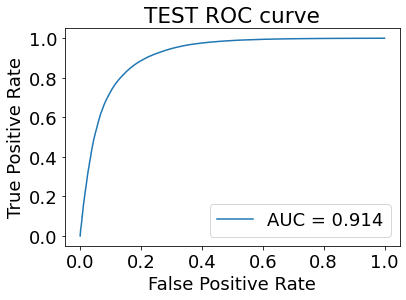

AUC: 0.914
Optimal threshold: 0.120
215640/215640 [==============================] - 48s 224us/sample - loss: 0.6159 - acc: 0.7409
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 2


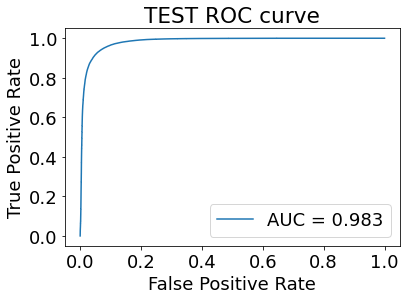

AUC: 0.983
Optimal threshold: 0.435
215640/215640 [==============================] - 48s 223us/sample - loss: 0.1713 - acc: 0.9353
{32, 5, 30, 7}
TEST
Mouse 2


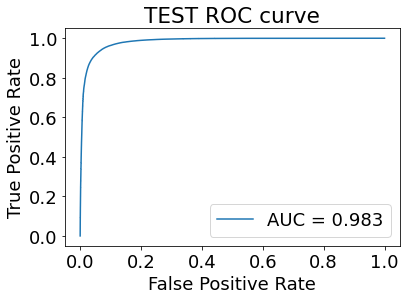

AUC: 0.983
Optimal threshold: 0.612
215640/215640 [==============================] - 48s 223us/sample - loss: 0.1540 - acc: 0.9417
{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 2


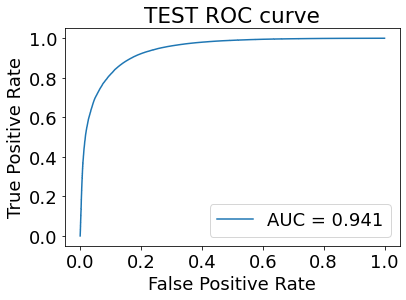

AUC: 0.941
Optimal threshold: 0.205
215640/215640 [==============================] - 49s 225us/sample - loss: 0.4531 - acc: 0.8260
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 3


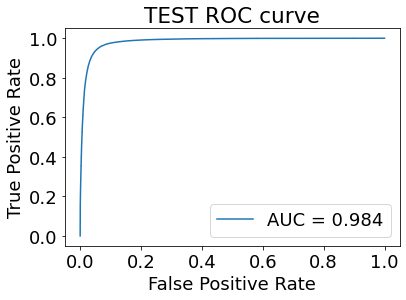

AUC: 0.984
Optimal threshold: 0.661
251580/251580 [==============================] - 57s 225us/sample - loss: 0.1499 - acc: 0.9492
{32, 5, 30, 7}
TEST
Mouse 3


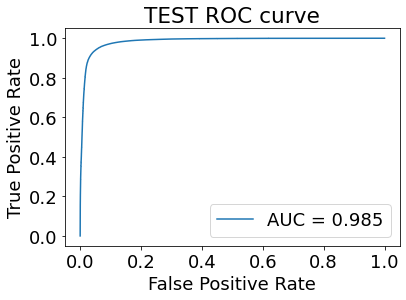

AUC: 0.985
Optimal threshold: 0.683
251580/251580 [==============================] - 56s 221us/sample - loss: 0.1455 - acc: 0.9481
{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 3


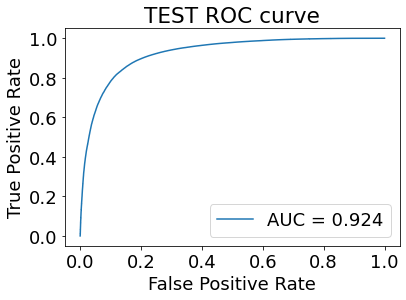

AUC: 0.924
Optimal threshold: 0.278
251580/251580 [==============================] - 57s 227us/sample - loss: 0.4632 - acc: 0.8267
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 3


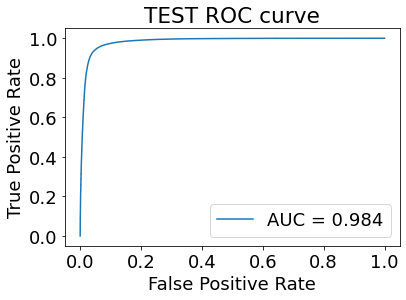

AUC: 0.984
Optimal threshold: 0.774
251580/251580 [==============================] - 58s 231us/sample - loss: 0.1478 - acc: 0.9471
{32, 5, 30, 7}
TEST
Mouse 3


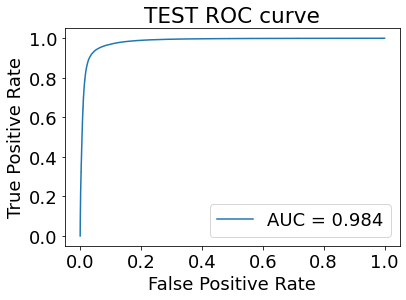

AUC: 0.984
Optimal threshold: 0.717
251580/251580 [==============================] - 58s 231us/sample - loss: 0.1484 - acc: 0.9464
{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 3


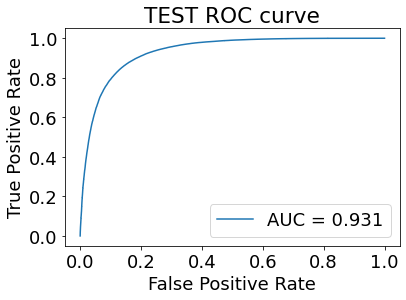

AUC: 0.931
Optimal threshold: 0.727
251580/251580 [==============================] - 58s 230us/sample - loss: 0.3284 - acc: 0.8728
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 3


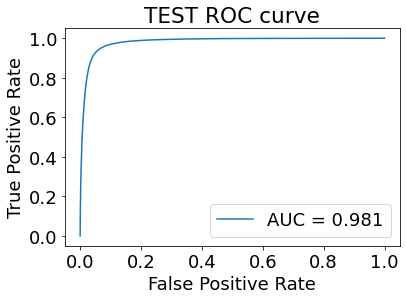

AUC: 0.981
Optimal threshold: 0.720
251580/251580 [==============================] - 57s 227us/sample - loss: 0.1580 - acc: 0.9448
{32, 5, 30, 7}
TEST
Mouse 3


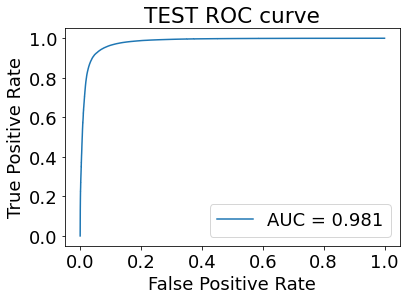

AUC: 0.981
Optimal threshold: 0.599
251580/251580 [==============================] - 57s 227us/sample - loss: 0.1611 - acc: 0.9413
{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 3


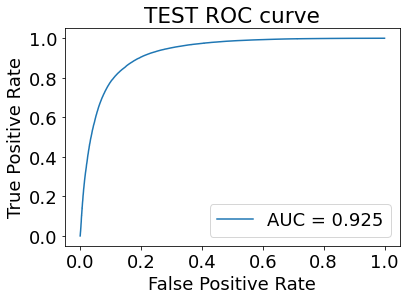

AUC: 0.925
Optimal threshold: 0.534
251580/251580 [==============================] - 58s 229us/sample - loss: 0.3618 - acc: 0.8631
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 3


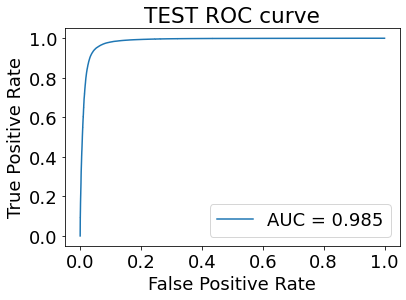

AUC: 0.985
Optimal threshold: 0.783
251580/251580 [==============================] - 58s 230us/sample - loss: 0.1385 - acc: 0.9529
{32, 5, 30, 7}
TEST
Mouse 3


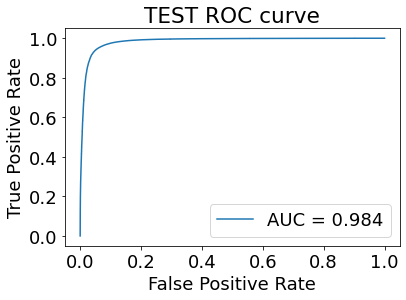

AUC: 0.984
Optimal threshold: 0.564
251580/251580 [==============================] - 59s 233us/sample - loss: 0.1474 - acc: 0.9482
{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 3


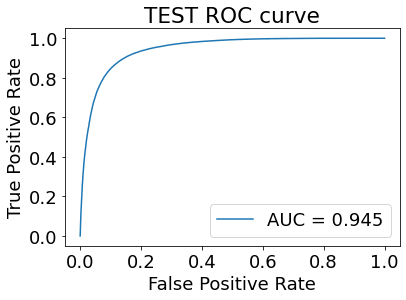

AUC: 0.945
Optimal threshold: 0.449
251580/251580 [==============================] - 59s 235us/sample - loss: 0.3128 - acc: 0.8782
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 4


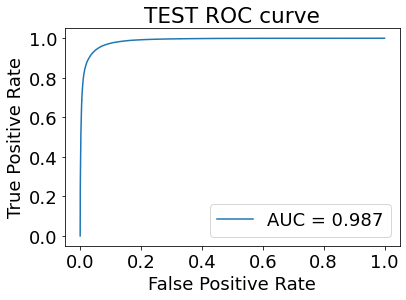

AUC: 0.987
Optimal threshold: 0.742
269550/269550 [==============================] - 63s 232us/sample - loss: 0.1507 - acc: 0.9456
{32, 5, 30, 7}
TEST
Mouse 4


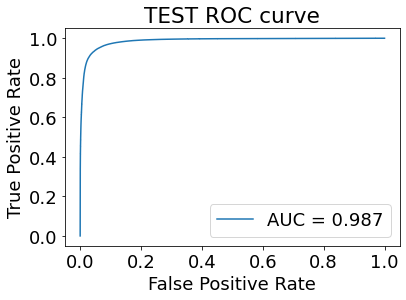

AUC: 0.987
Optimal threshold: 0.681
269550/269550 [==============================] - 63s 234us/sample - loss: 0.1464 - acc: 0.9451
{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 4


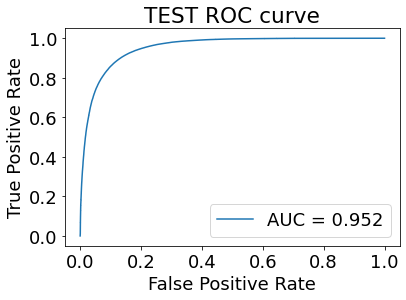

AUC: 0.952
Optimal threshold: 0.397
269550/269550 [==============================] - 63s 233us/sample - loss: 0.2942 - acc: 0.8800
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 4


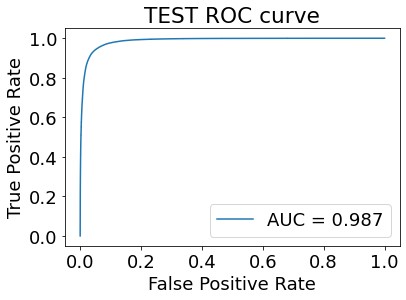

AUC: 0.987
Optimal threshold: 0.774
269550/269550 [==============================] - 63s 232us/sample - loss: 0.1470 - acc: 0.9460
{32, 5, 30, 7}
TEST
Mouse 4


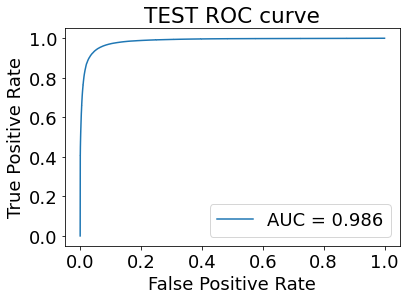

AUC: 0.986
Optimal threshold: 0.767
269550/269550 [==============================] - 62s 231us/sample - loss: 0.1599 - acc: 0.9412
{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 4


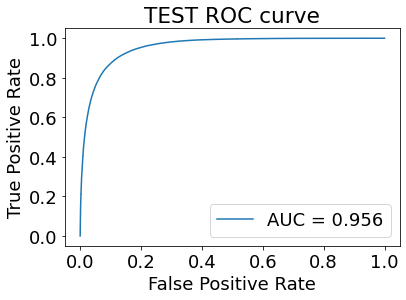

AUC: 0.956
Optimal threshold: 0.317
269550/269550 [==============================] - 63s 233us/sample - loss: 0.3023 - acc: 0.8766
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 4


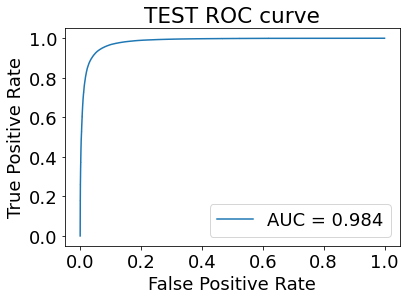

AUC: 0.984
Optimal threshold: 0.637
269550/269550 [==============================] - 63s 233us/sample - loss: 0.1593 - acc: 0.9408
{32, 5, 30, 7}
TEST
Mouse 4


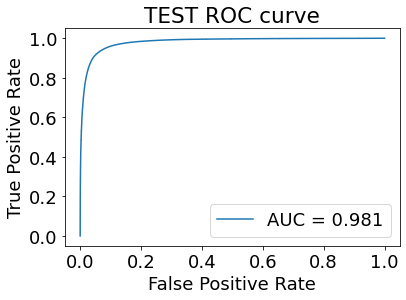

AUC: 0.981
Optimal threshold: 0.680
269550/269550 [==============================] - 63s 233us/sample - loss: 0.1770 - acc: 0.9349
{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 4


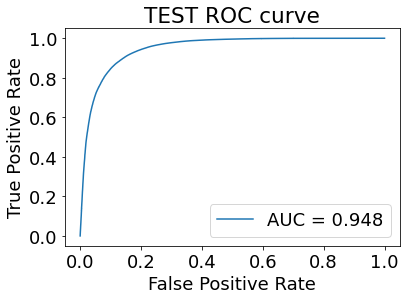

AUC: 0.948
Optimal threshold: 0.632
269550/269550 [==============================] - 63s 235us/sample - loss: 0.3007 - acc: 0.8848
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 4


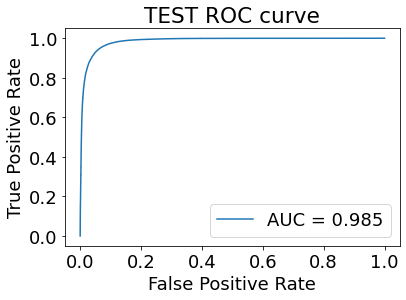

AUC: 0.985
Optimal threshold: 0.521
269550/269550 [==============================] - 64s 236us/sample - loss: 0.1481 - acc: 0.9444
{32, 5, 30, 7}
TEST
Mouse 4


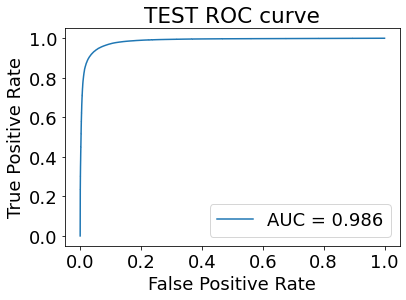

AUC: 0.986
Optimal threshold: 0.660
269550/269550 [==============================] - 65s 240us/sample - loss: 0.1496 - acc: 0.9442
{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 4


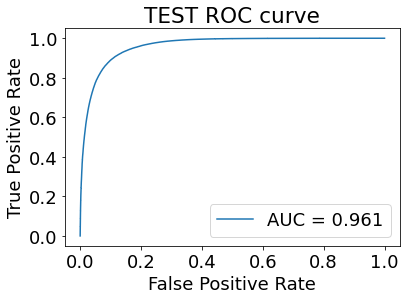

AUC: 0.961
Optimal threshold: 0.398
269550/269550 [==============================] - 65s 240us/sample - loss: 0.2725 - acc: 0.8915
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 5


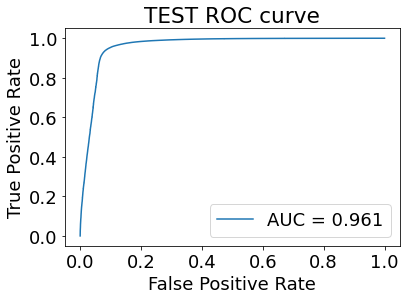

AUC: 0.961
Optimal threshold: 0.923
215640/215640 [==============================] - 51s 237us/sample - loss: 0.1754 - acc: 0.9421
{32, 5, 30, 7}
TEST
Mouse 5


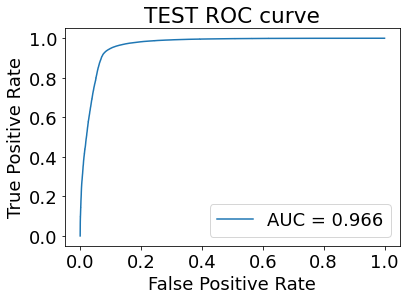

AUC: 0.966
Optimal threshold: 0.879
215640/215640 [==============================] - 52s 239us/sample - loss: 0.1602 - acc: 0.9467
{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 5


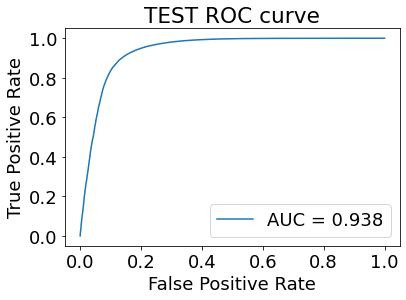

AUC: 0.938
Optimal threshold: 0.924
215640/215640 [==============================] - 50s 232us/sample - loss: 0.2365 - acc: 0.9235
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 5


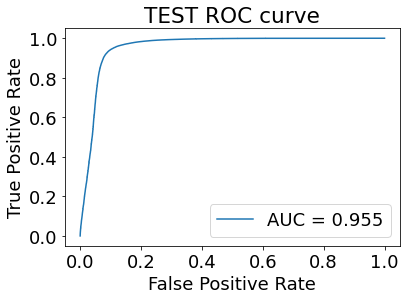

AUC: 0.955
Optimal threshold: 0.846
215640/215640 [==============================] - 52s 239us/sample - loss: 0.1665 - acc: 0.9480
{32, 5, 30, 7}
TEST
Mouse 5


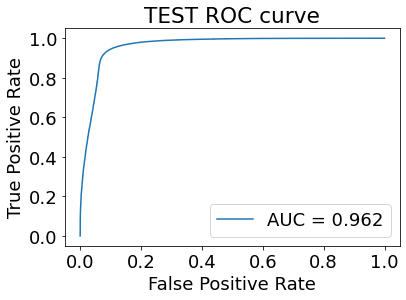

AUC: 0.962
Optimal threshold: 0.882
215640/215640 [==============================] - 53s 244us/sample - loss: 0.1685 - acc: 0.9447
{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 5


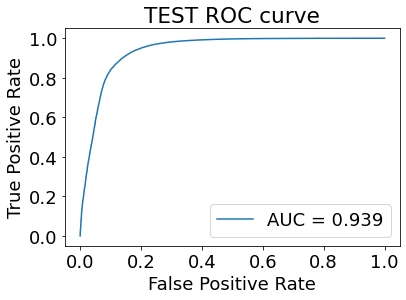

AUC: 0.939
Optimal threshold: 0.840
215640/215640 [==============================] - 54s 250us/sample - loss: 0.2156 - acc: 0.9268
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 5


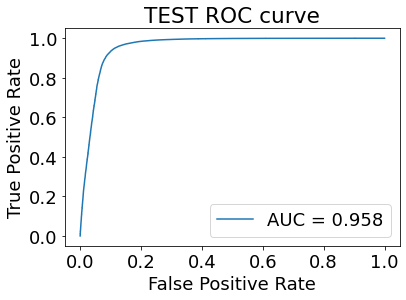

AUC: 0.958
Optimal threshold: 0.739
215640/215640 [==============================] - 53s 247us/sample - loss: 0.1659 - acc: 0.9481
{32, 5, 30, 7}
TEST
Mouse 5


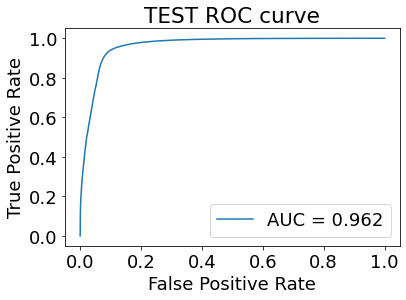

AUC: 0.962
Optimal threshold: 0.861
215640/215640 [==============================] - 53s 245us/sample - loss: 0.1685 - acc: 0.9434
{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 5


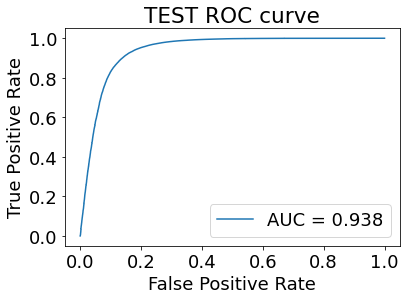

AUC: 0.938
Optimal threshold: 0.817
215640/215640 [==============================] - 53s 244us/sample - loss: 0.2090 - acc: 0.9292
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 5


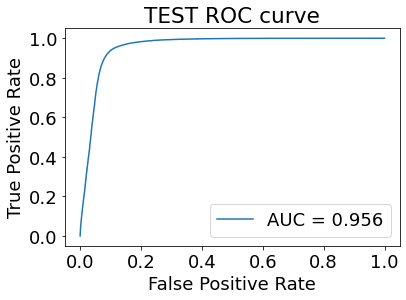

AUC: 0.956
Optimal threshold: 0.803
215640/215640 [==============================] - 52s 241us/sample - loss: 0.1661 - acc: 0.9473
{32, 5, 30, 7}
TEST
Mouse 5


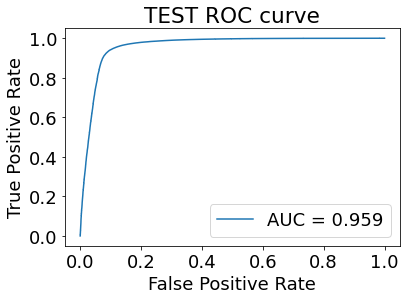

AUC: 0.959
Optimal threshold: 0.828
215640/215640 [==============================] - 52s 241us/sample - loss: 0.1647 - acc: 0.9447
{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TEST
Mouse 5


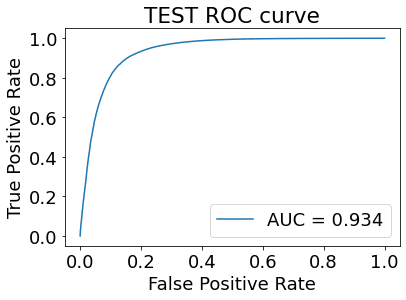

AUC: 0.934
Optimal threshold: 0.845
215640/215640 [==============================] - 54s 252us/sample - loss: 0.2282 - acc: 0.9174


In [17]:
df_AUC = pandas.DataFrame(numpy.zeros([20, 5]), columns=['VALID','TEST']+list(REGIONS.keys()))
df_LOSS = pandas.DataFrame(numpy.zeros([20, 5]), columns=['VALID','TEST']+list(REGIONS.keys()))
df_ACC = pandas.DataFrame(numpy.zeros([20, 5]), columns=['VALID','TEST']+list(REGIONS.keys()))

l = [1, 2, 3, 4, 5]
for raw, v in enumerate(itertools.permutations(l, 2)):
    TEST = [v[0]]
    VALID = [v[1]]
    df_AUC['TEST'][raw] = df_LOSS['TEST'][raw] = df_ACC['TEST'][raw] = v[0]
    df_AUC['VALID'][raw] = df_LOSS['VALID'][raw] = df_ACC['VALID'][raw] = v[1]
    for REGION in REGIONS:
        print(REGIONS[REGION])
        testX, testY = Get_Dataset(TEST, REGIONS[REGION])
        input_test = testX.transpose(0,2,1)
        for ModelType in Models:
            ver = f'{ModelType}_{VALID}_{TEST}'
            model_file_path = f'models_N20/{ModelType}/{REGION}/best_model_{ver}.h5'
            model = load_model(model_file_path)
            test_pred = model.predict(input_test)
            df_AUC[REGION][raw] = plot_roc(test_pred, testY, "TEST")
            results = model.evaluate(input_test,testY)
            df_LOSS[REGION][raw] = results[0]
            df_ACC[REGION][raw] = results[1]

In [18]:
df_AUC.to_csv('N20_4_region_result_AUC.csv')
df_AUC

,VALID,TEST,Whole_region,Region_6-8-31-33,Other_than_4_regions
0,2.0,1.0,0.958076,0.908059,0.930733
1,3.0,1.0,0.955052,0.917935,0.940353
2,4.0,1.0,0.960126,0.930352,0.929553
3,5.0,1.0,0.958905,0.914795,0.939944
4,1.0,2.0,0.986540,0.981464,0.932955
5,3.0,2.0,0.985850,0.983425,0.949005
6,4.0,2.0,0.981014,0.983939,0.914419
7,5.0,2.0,0.982591,0.982985,0.940700
8,1.0,3.0,0.983654,0.984636,0.924096
9,2.0,3.0,0.983640,0.983612,0.931322


In [19]:
df_LOSS.to_csv('N20_4_region_result_BCEloss.csv')
df_LOSS

,VALID,TEST,Whole_region,Region_6-8-31-33,Other_than_4_regions
0,2.0,1.0,0.255329,0.380460,0.491638
1,3.0,1.0,0.336411,0.371804,0.330403
2,4.0,1.0,0.326430,0.352239,0.354768
3,5.0,1.0,0.344918,0.369238,0.338047
4,1.0,2.0,0.144285,0.167237,0.689020
5,3.0,2.0,0.162489,0.153204,0.437375
6,4.0,2.0,0.194369,0.153886,0.615855
7,5.0,2.0,0.171304,0.153960,0.453069
8,1.0,3.0,0.149898,0.145466,0.463179
9,2.0,3.0,0.147848,0.148406,0.328359


In [20]:
df_ACC.to_csv('N20_4_region_result_Accuracy.csv')
df_ACC

,VALID,TEST,Whole_region,Region_6-8-31-33,Other_than_4_regions
0,2.0,1.0,0.891395,0.837623,0.833273
1,3.0,1.0,0.853119,0.843052,0.870845
2,4.0,1.0,0.855937,0.853210,0.857965
3,5.0,1.0,0.852390,0.841928,0.854707
4,1.0,2.0,0.948456,0.936607,0.764960
5,3.0,2.0,0.940442,0.942242,0.841129
6,4.0,2.0,0.923933,0.942135,0.740864
7,5.0,2.0,0.935318,0.941685,0.825983
8,1.0,3.0,0.949229,0.948088,0.826687
9,2.0,3.0,0.947118,0.946395,0.872760
